In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import re
import glob
import nltk
import numpy as np
from fit_generator import label_from_id, all_labels
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate
from keras.preprocessing.text import Tokenizer
from keras import optimizers
from keras.callbacks import ModelCheckpoint 
from fnn_helper import PlotLosses
from keras import regularizers
from sklearn.model_selection import train_test_split
from gensim.models import word2vec as w2v
import matplotlib.pyplot as plt
import scipy
import iterator_and_text_cleaner as it

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
w2v_model = w2v.Word2Vec.load('word2vec.model')
word2index = { word:idx for idx,word in enumerate(w2v_model.wv.index2word) }

In [4]:
source_path = '../converted/'
words_per_article = 300

In [5]:
txt_files = glob.glob(source_path + '*')
len(txt_files)

104785

In [6]:
Y = np.load('y.npy')
NUM_CATEGORIES = Y.shape[1]

In [7]:
Y.shape

(104785, 5)

In [8]:
x_train_files, x_test_files, y_train, y_test = train_test_split(txt_files, Y, test_size=0.33)

In [9]:
len(x_train_files)

70205

In [10]:
def batch_generator(x_files, y, samples_per_epoch, batch_size):
    number_of_batches = samples_per_epoch//batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    x_files =  np.array(x_files)[shuffle_index]
    y = y[shuffle_index]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = []
        for xfile in x_files[index_batch]:
            X_batch.append(it.article_indices(word2index, xfile, words_per_article))
        y_batch = y[index_batch]
        counter += 1
        yield(np.array(X_batch),y_batch)
        if (counter >= number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0

In [11]:
# Model Hyperparameters
filter_sizes = (3, 4, 5)
num_filters = 3
dropout_prob = 0.5
hidden_dims = 50

# Training parameters
batch_size = 32
num_epochs = 10

In [15]:
model_input = Input(shape=(words_per_article,), name="Input")
#embedding = w2v_model.wv.get_keras_embedding(train_embeddings=False)
embedding = Embedding(input_dim=len(w2v_model.wv.vocab), output_dim=200, trainable=False)
conv_input = embedding(model_input)

conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(conv_input)
    conv = MaxPooling1D(pool_size=10)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks)
# z = Dropout(dropout_prob)(z)
# z = Dense(hidden_dims, activation="relu")(z)
model_output = Dense(NUM_CATEGORIES, activation="sigmoid")(z)
model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 300, 200)     9463400     Input[0][0]                      
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 298, 3)       1803        embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 297, 3)       2403        embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_6 (

In [16]:
def train_model(model, x_train_files, x_test_files, y_train, y_test, weights_file=None, batch_size=16, epochs=10):
    plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None)
    callbacks = [plot_losses]

    if weights_file != None:
        checkpointer = ModelCheckpoint(filepath=weights_file, verbose=0, save_best_only=True)
        callbacks.append(checkpointer)

    steps_per_epoch = y_train.shape[0] // batch_size
    print("Steps per epoch = ", steps_per_epoch)
    generator = batch_generator(x_train_files, y_train, samples_per_epoch=steps_per_epoch, batch_size=batch_size)
    vals_per_epoc = y_test.shape[0] // batch_size
    val_generator = batch_generator(x_test_files, y_test, samples_per_epoch=vals_per_epoc, batch_size=batch_size)
    result = model.fit_generator(
        generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=vals_per_epoc,
        verbose=1,
        callbacks=callbacks,
    )
    return result

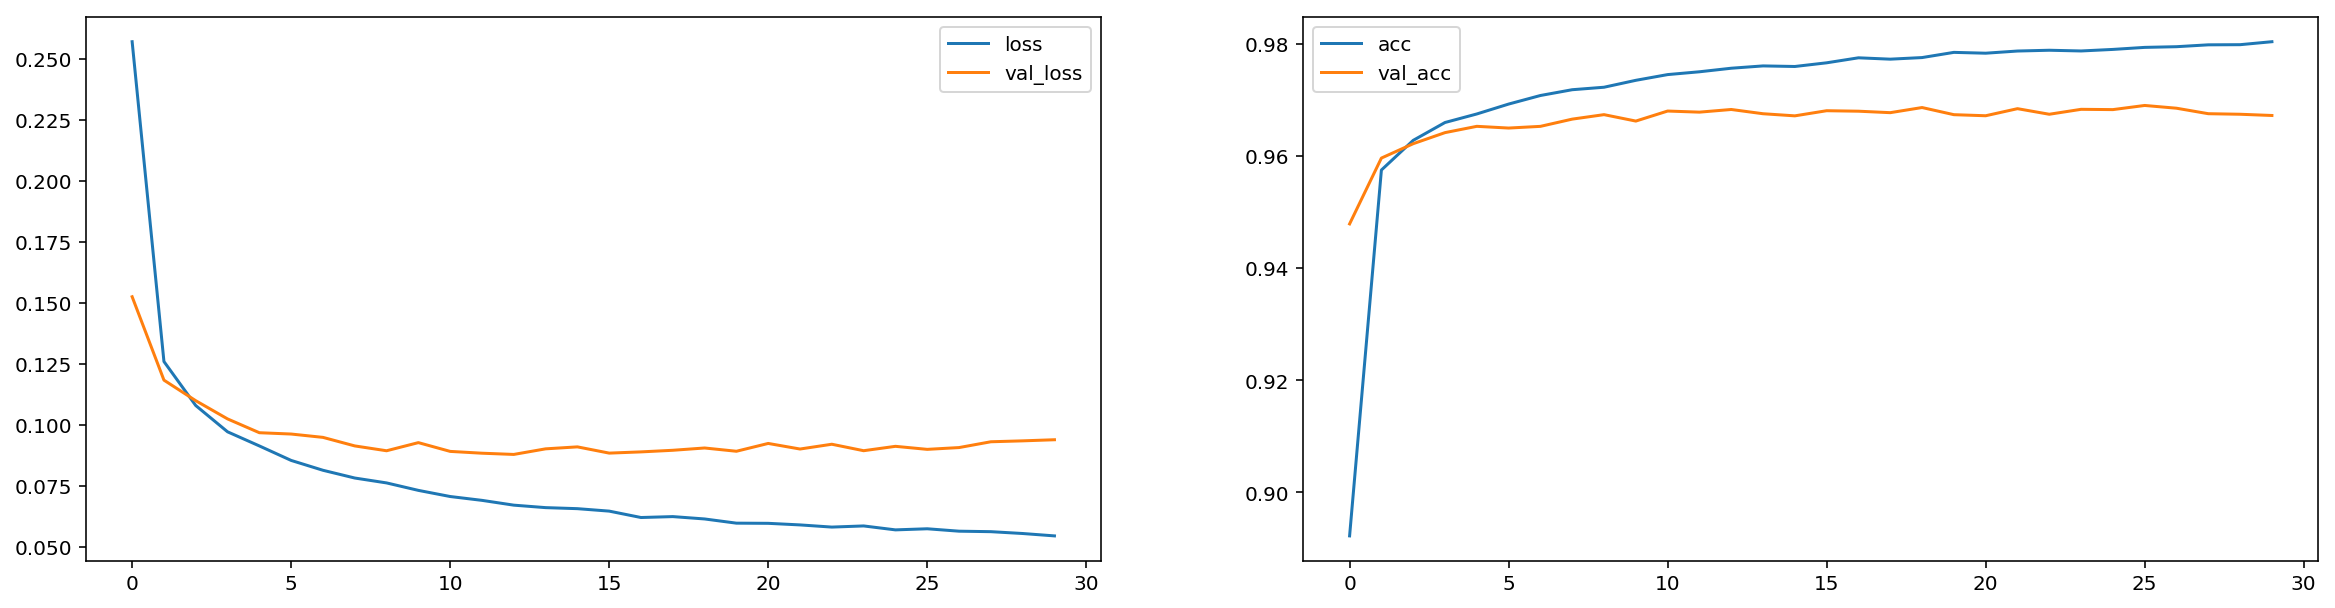

2193/2193 [==============================] - 110s 50ms/step - loss: 0.0545 - acc: 0.9803 - val_loss: 0.0939 - val_acc: 0.9672


In [17]:
train_model(model, x_train_files, x_test_files, y_train, y_test, weights_file='w2vec-cnn-3.weights',
            batch_size=batch_size, epochs=30)

In [176]:
def predict_from_text(model, text):
    indices = np.array([it.text_indices(word2index, text, words_per_article)])
    probs = model.predict(indices)[0]
    for i, proba in enumerate(probs):
        if proba > .3:
            print(all_labels[i], proba)

In [177]:
cnn_politics = "Today, Democrats hold just one of the 26 Senate seats in the 13 states that, like Alabama,\
have voted Republican in every presidential election since 1992. Republicans in turn hold just one of the 30 \
Senate seats in the 15 states that voted Democratic in all seven presidential elections since then. That means \
if Jones wins he would be just the third senator from the opposing party to hold one of the 56 Senate seats in\
the 28 states that have voted the same way in each of the past seven presidential elections.\
The consistency between presidential and Senate results is much, much greater than it used to be,\
says Alan Abramowitz, a political scientist at Emory University."

In [178]:
predict_from_text(model, cnn_politics)

POLITICS 0.998806


In [179]:
bloomberg = "House and Senate negotiators are planning to limit the deduction for mortgage interest to\
loans of $750,000 or less, according to Representative Tom MacArthur, a New Jersey Republican. MacArthur\
said the $750,000 limit would be positive for his district compared to the House bill. He added that lawmakers\
are still discussing whether to allow a deduction for state and local income taxes as part of a proposed cap of \
$10,000 for property taxes. He also said he’s pushing to preserve a deduction for large medical expenses that \
the House bill would called for eliminating. Current law limits the mortgage deduction to loans of $1 million\
or less. The tax break is one of the sticking points House and Senate lawmakers have been trying to resolve this\
week. The House bill calls for slashing the deduction cap for new purchases of homes in half -- to loans of \
$500,000 or less. The Senate legislation preserved the current limit."

In [180]:
predict_from_text(model, bloomberg)

ECONOMICS 0.916684
POLITICS 0.984743


In [181]:
bloomberg2 = "Despite a recent bounce back, analysts and investors say the greenback could lose more ground\
against the euro and yen as the prospect of strong economic growth and tighter monetary policy outside the \
U.S. more than offsets higher interest rates at home. The dollar is down more than 7 percent versus the world’s\
major currencies this year, the most in over a decade. The economic growth “we’re seeing in Europe, emerging \
markets and the rest of the world will likely cause the dollar to sell off again,” said Erin Browne, the head \
of asset allocation at UBS Asset Management, which oversees about $770 billion. When it comes to what central\
banks in Europe and Japan might do, “there’s very little priced in.”"

In [182]:
predict_from_text(model, bloomberg2)

ECONOMICS 0.999976


In [183]:
cnn_sports = "With 14 wins and just one draw so far, Manchester City are on pace to pull off the most dominant\
season in Premier League history -- but can they go undefeated? Since drawing with Everton in their second \
league game of the season, Pep Guardiola's City has won 13-matches in a row while posting a staggering 36 \
goal difference. heir Champions League performances been nearly as impressive, with City winning its first \
five matches and locking up the group before losing to Shakhtar Donetsk earlier this week."

In [184]:
predict_from_text(model, cnn_sports)

SPORTS 0.982981


In [185]:
cnn_entertainment = "Disney's next installment in the \"Star Wars\" saga has become Fandango's top advance \
ticket-seller of the year, the online ticket site reported on Tuesday. The film, which doesn't officially open \
in North America until Friday with previews beginning Thursday night, toppled another Disney production, \
\"Beauty and the Beast,\" which came out in March, for the top spot. \"The Last Jedi\" is the biggest \
ticket pre-seller for Fandango since the series' last film, 2015's \"Star Wars: The Force Awakens,\" which \
went on to become the biggest opening in film history. \"The Last Jedi\" debuts in more than 4,100 \
theaters domestically and is on track for an opening weekend in the $200 million range. However, \
some box office analysts are saying the movie has the chance to open even higher. Fandango also put \
together some interesting data on why audiences are looking forward to the film, which stars Mark Hamill\
as Luke Skywalker and Daisy Ridley as Rey."

In [186]:
predict_from_text(model, cnn_entertainment)

ENTERTAINMENT 0.871016


In [188]:
cnn_tech = "The company released a trio of free photo apps on Monday. Created as experiments by different \
Google (GOOG) departments, the simple mobile apps include a photo booth with pose-detecting powers, a way\
to remix videos like a DJ, and a tool for turning any mundane adventure into a comic book panel.\
The company is calling the free downloads Appsperiments, a clunky portmanteau of apps and experiments.\
The tools offer a peek into the future of smartphone photography, which will increasingly rely on effects \
created by software. An early example is the Google Pixel 2 portrait mode, which uses software to fake a \
shallow depth-of-field effect. The next generation of cameras will have the capability to blend hardware\
and computer vision algorithms,\" said Alex Kauffmann, an interaction researcher at Google Research, in a blog post."

In [189]:
predict_from_text(model, cnn_tech)

ECONOMICS 0.393657
ENTERTAINMENT 0.515269
TECHNOLOGY 0.313365
